In [4]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa
import soundfile as sf
import sounddevice as sd
import torchaudio
from scipy.io.wavfile import write
from scipy.spatial.distance import cosine
import noisereduce as nr
import matplotlib.pyplot as plt
import seaborn as sns

import faiss
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score


import torch
import tensorflow as tf
import tensorflow_hub as hub
from transformers import Wav2Vec2Processor, Wav2Vec2Model


In [ ]:
df_meta = pd.read_csv("audio_metadata.csv" , index_col=False )

In [ ]:
querry_folder = "recorded_queries_clean"

In [ ]:
querry_audio_paths = [os.path.join(querry_folder,path) for path in os.listdir(querry_folder)]

In [ ]:
zero_digit_path = df_meta[df_meta['digit']==0].iloc[0]['path']
print(zero_digit_path)


In [ ]:
# Loading both audios
y_q_raw, sr_q = librosa.load(querry_audio_paths
df_meta = pd.read_csv("audio_metadata.csv" , index_col=False )
querry_folder = "recorded_queries_clean"
querry_audio_paths = [os.path.join(querry_folder,path) for path in os.listdir(querry_folder)]
zero_digit_path = df_meta[df_meta['digit']==0].iloc[0]['path']
print(zero_digit_path)

[0], sr=16000)
y_d_raw, sr_d = librosa.load(zero_digit_path, sr=16000)

# # Trimming silent part for fair comparison
# y_q_trim, _ = librosa.effects.trim(y_q, top_db=30)
# y_d_trim, _ = librosa.effects.trim(y_d, top_db=30)

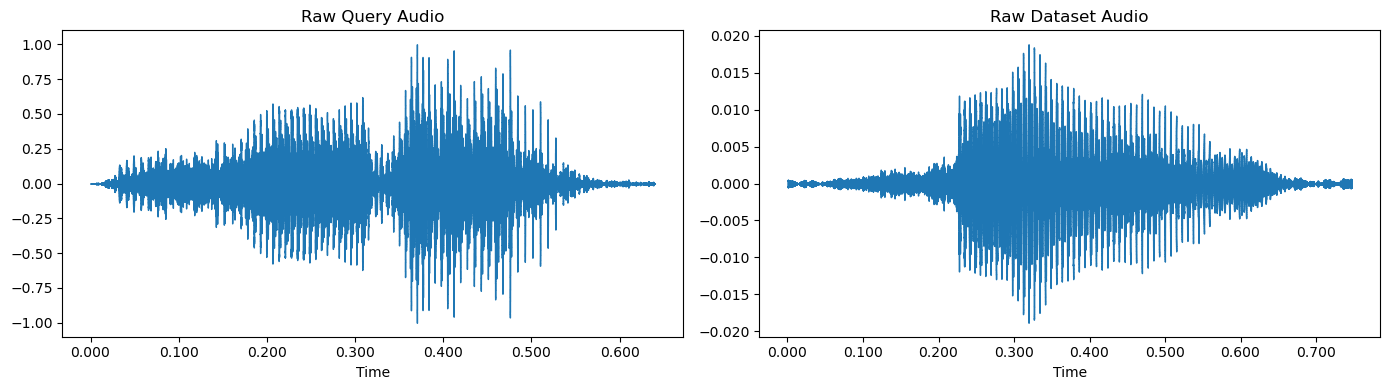

In [7]:
# --- Raw Waveform ---
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
librosa.display.waveshow(y_q_raw, sr=sr_q)
plt.title("Raw Query Audio")

plt.subplot(1, 2, 2)
librosa.display.waveshow(y_d_raw, sr=sr_d)
plt.title("Raw Dataset Audio")
plt.tight_layout()
plt.show()

In [8]:
#Duration
print(f" Duration - Query: {librosa.get_duration(y=y_q_raw, sr=sr_q):.2f}s")
print(f" Duration - Dataset: {librosa.get_duration(y=y_d_raw, sr=sr_d):.2f}s")

⏱ Duration - Query: 0.64s
⏱ Duration - Dataset: 0.75s


In [9]:
# Features Before Trimming
def scalar_audio_features(y, sr, label="Audio"):
    rms = np.mean(librosa.feature.rms(y=y))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    print(f"\n {label} Features:")
    print(f"RMS Energy:         {rms:.4f}")
    print(f"Zero Crossing Rate: {zcr:.4f}")
    print(f"Spectral Centroid:  {centroid:.2f} Hz")

scalar_audio_features(y_q_raw, sr_q, "Query")
scalar_audio_features(y_d_raw, sr_d, "Dataset")


📌 Query Features:
RMS Energy:         0.1687
Zero Crossing Rate: 0.1266
Spectral Centroid:  1936.94 Hz

📌 Dataset Features:
RMS Energy:         0.0029
Zero Crossing Rate: 0.1208
Spectral Centroid:  1587.17 Hz


In [32]:
sr_q, sr_d = 16000 , 16000

Waveforms & Spectograms

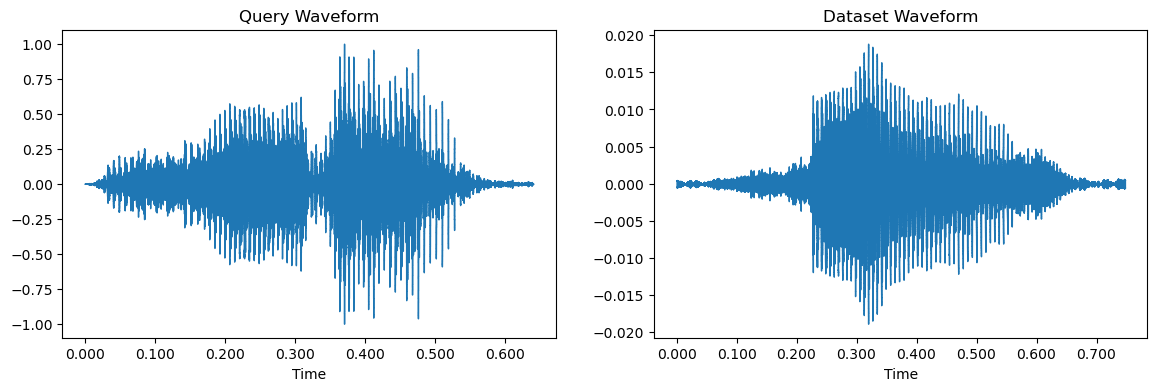

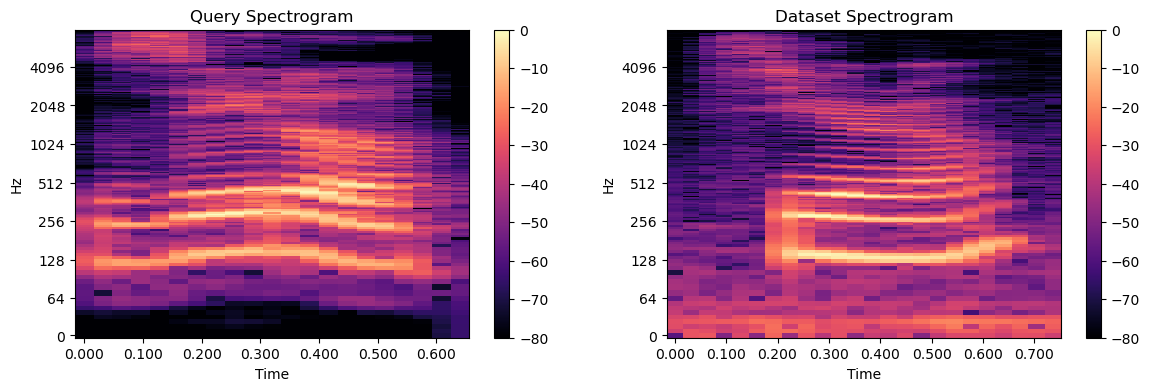

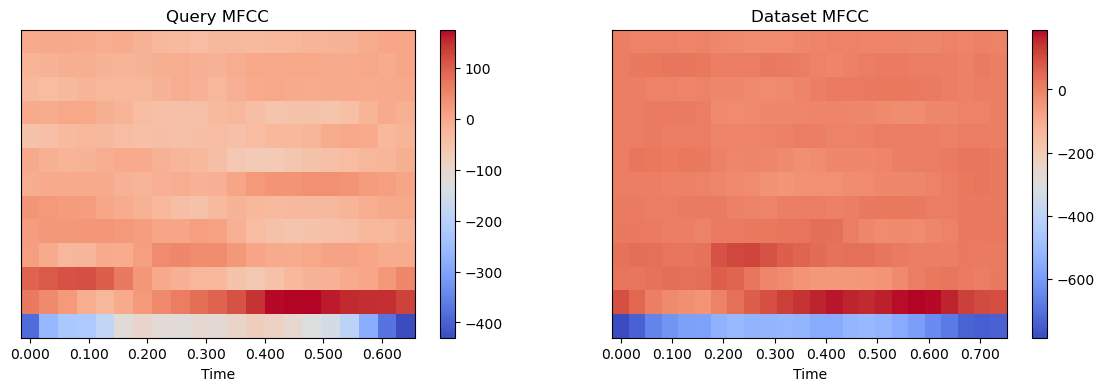

📊 Scalar Feature Comparison:
RMS Energy     - Query: 0.1687, Dataset: 0.0029
Zero Crossing  - Query: 0.1266, Dataset: 0.1208
Spectral Cent. - Query: 1936.94, Dataset: 1587.17
Duration (s)   - Query: 0.64, Dataset: 0.75


In [34]:
def plot_waveforms(y1, y2, sr1, sr2, title1='Query', title2='Dataset'):
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y1, sr=sr1)
    plt.title(f'{title1} Waveform')
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(y2, sr=sr2)
    plt.title(f'{title2} Waveform')
    plt.show()

def plot_spectrograms(y1, y2, sr1, sr2, title1='Query', title2='Dataset'):
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    S1 = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)
    librosa.display.specshow(S1, sr=sr1, x_axis='time', y_axis='log')
    plt.title(f'{title1} Spectrogram')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    S2 = librosa.amplitude_to_db(np.abs(librosa.stft(y2)), ref=np.max)
    librosa.display.specshow(S2, sr=sr2, x_axis='time', y_axis='log')
    plt.title(f'{title2} Spectrogram')
    plt.colorbar()
    plt.show()

def plot_mfccs(y1, y2, sr1, sr2, n_mfcc=13):
    mfcc_q = librosa.feature.mfcc(y = y1, sr=sr1, n_mfcc=n_mfcc)
    mfcc_d = librosa.feature.mfcc(y = y2, sr=sr2, n_mfcc=n_mfcc)
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    librosa.display.specshow(mfcc_q, x_axis='time', sr=sr1)
    plt.title('Query MFCC')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    librosa.display.specshow(mfcc_d, x_axis='time', sr=sr2)
    plt.title('Dataset MFCC')
    plt.colorbar()
    plt.show()

def compare_scalar_features(y1, y2):
    rms_q = np.mean(librosa.feature.rms(y=y1))
    rms_d = np.mean(librosa.feature.rms(y=y2))
    zcr_q = np.mean(librosa.feature.zero_crossing_rate(y1))
    zcr_d = np.mean(librosa.feature.zero_crossing_rate(y2))
    cent_q = np.mean(librosa.feature.spectral_centroid(y=y1, sr=sr_q))
    cent_d = np.mean(librosa.feature.spectral_centroid(y=y2, sr=sr_d))
    dur_q = librosa.get_duration(y=y1, sr=sr_q)
    dur_d = librosa.get_duration(y=y2, sr=sr_d)
    
    print("📊 Scalar Feature Comparison:")
    print(f"RMS Energy     - Query: {rms_q:.4f}, Dataset: {rms_d:.4f}")
    print(f"Zero Crossing  - Query: {zcr_q:.4f}, Dataset: {zcr_d:.4f}")
    print(f"Spectral Cent. - Query: {cent_q:.2f}, Dataset: {cent_d:.2f}")
    print(f"Duration (s)   - Query: {dur_q:.2f}, Dataset: {dur_d:.2f}")

plot_waveforms(y_q_raw, y_d_raw, sr_q, sr_d)
plot_spectrograms(y_q_raw, y_d_raw, sr_q, sr_d)
plot_mfccs(y_q_raw, y_d_raw, sr_q, sr_d)
compare_scalar_features(y_q_raw, y_d_raw)

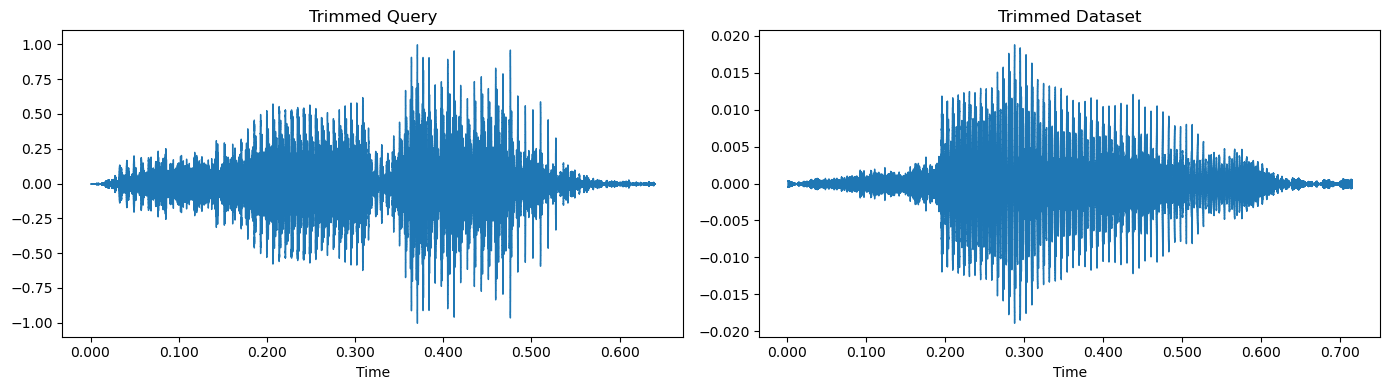

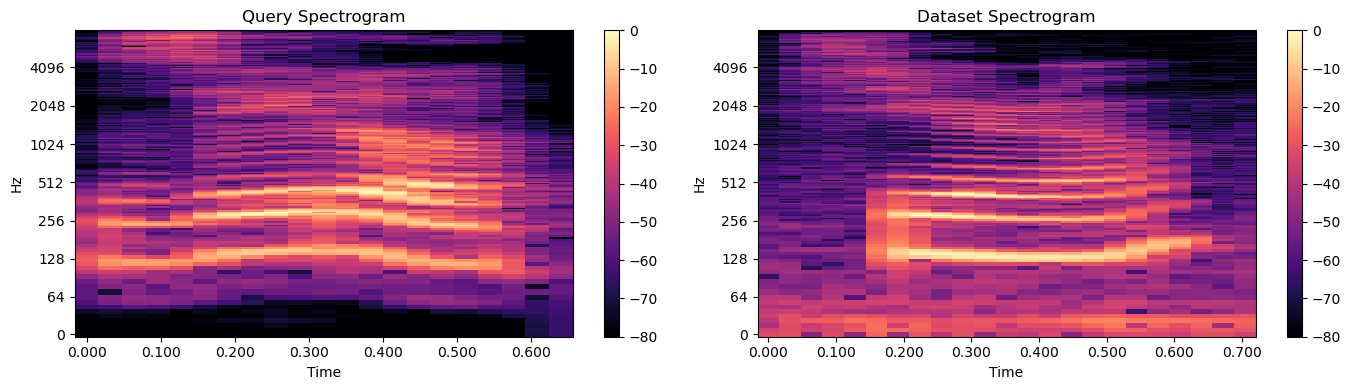

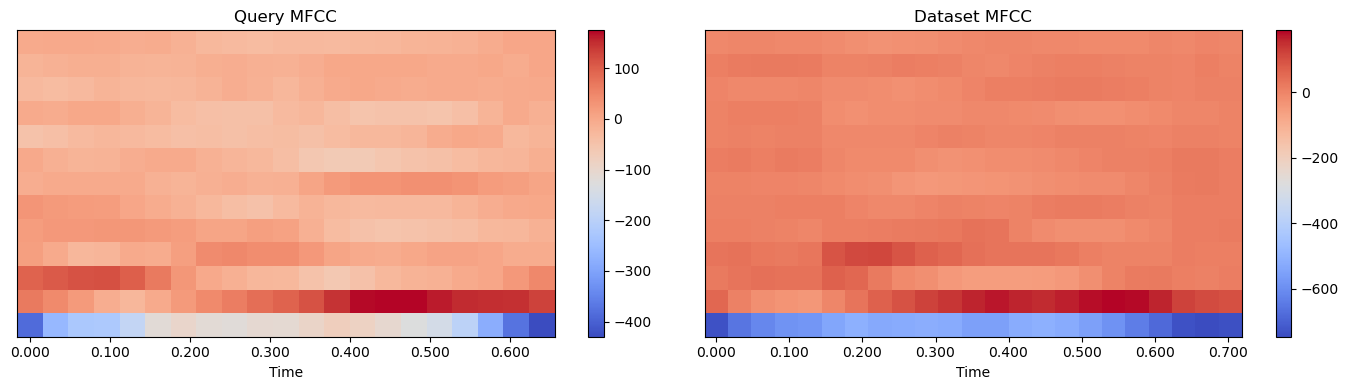

In [35]:
# Trim silence
y_q_trim, _ = librosa.effects.trim(y_q_raw, top_db=30)
y_d_trim, _ = librosa.effects.trim(y_d_raw, top_db=30)

# Waveforms
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
librosa.display.waveshow(y_q_trim, sr=sr_q)
plt.title("Trimmed Query")

plt.subplot(1, 2, 2)
librosa.display.waveshow(y_d_trim, sr=sr_d)
plt.title("Trimmed Dataset")
plt.tight_layout()
plt.show()

# Spectrogram
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
S_q = librosa.amplitude_to_db(np.abs(librosa.stft(y_q_trim)), ref=np.max)
librosa.display.specshow(S_q, sr=sr_q, x_axis='time', y_axis='log')
plt.title("Query Spectrogram")
plt.colorbar()

plt.subplot(1, 2, 2)
S_d = librosa.amplitude_to_db(np.abs(librosa.stft(y_d_trim)), ref=np.max)
librosa.display.specshow(S_d, sr=sr_d, x_axis='time', y_axis='log')
plt.title("Dataset Spectrogram")
plt.colorbar()
plt.tight_layout()
plt.show()

# MFCC
mfcc_q = librosa.feature.mfcc(y=y_q_trim, sr=sr_q, n_mfcc=13)
mfcc_d = librosa.feature.mfcc(y=y_d_trim, sr=sr_d, n_mfcc=13)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(mfcc_q, x_axis='time', sr=sr_q)
plt.title("Query MFCC")
plt.colorbar()

plt.subplot(1, 2, 2)
librosa.display.specshow(mfcc_d, x_axis='time', sr=sr_d)
plt.title("Dataset MFCC")
plt.colorbar()
plt.tight_layout()
plt.show()


Loading AudioMNIST audio signals

In [37]:
data = []

for path in tqdm(df_meta['path']):  
    y, sr = librosa.load(path, sr=16000)
    y = y / np.max(np.abs(y))  # normalize

    # Duration
    duration = librosa.get_duration(y=y, sr=sr)

    # Energy
    rms = np.mean(librosa.feature.rms(y=y))

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))

    # Spectral Features
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

    # MFCC mean
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Digit
    digit = os.path.basename(path).split('_')[0] 

    data.append({
        "path": path,
        "digit": digit,
        "duration": duration,
        "rms": rms,
        "zcr": zcr,
        "centroid": centroid,
        "bandwidth": bandwidth,
        "rolloff": rolloff,
        **{f"mfcc_{i+1}": val for i, val in enumerate(mfcc_mean)}
    })

df_audio = pd.DataFrame(data)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [21:51<00:00, 22.88it/s]


Loading Query Audio Signals

In [42]:
data_querry = []

for path in tqdm(os.listdir(querry_folder)):  
    path = os.path.join(querry_folder,path)
    y, sr = librosa.load(path, sr=16000)
    y = y / np.max(np.abs(y))  # normalize

    # Duration
    duration = librosa.get_duration(y=y, sr=sr)

    # Energy
    rms = np.mean(librosa.feature.rms(y=y))

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))

    # Spectral Features
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

    # MFCC mean 
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Digit
    digit = os.path.basename(path).split('_')[0]  

    data_querry.append({
        "path": path,
        "digit": digit,
        "duration": duration,
        "rms": rms,
        "zcr": zcr,
        "centroid": centroid,
        "bandwidth": bandwidth,
        "rolloff": rolloff,
        **{f"mfcc_{i+1}": val for i, val in enumerate(mfcc_mean)}
    })

df_querry = pd.DataFrame(data_querry)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 23.25it/s]


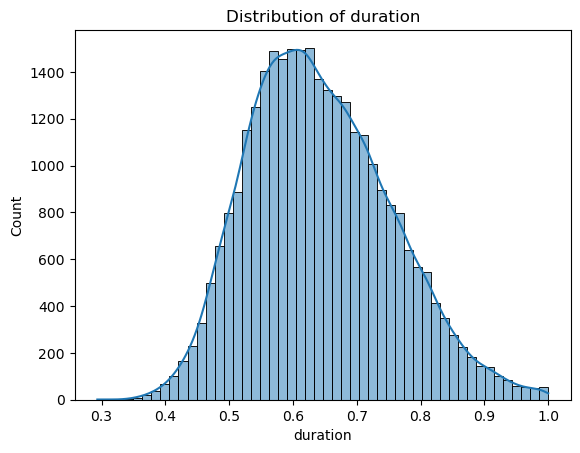

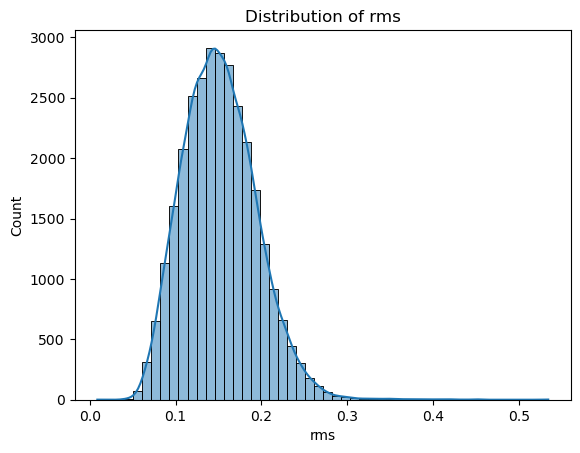

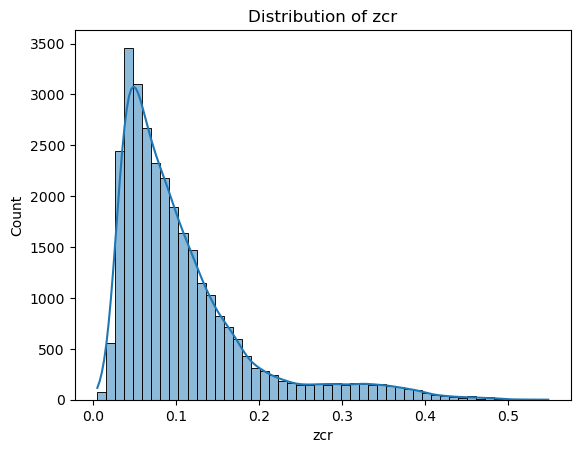

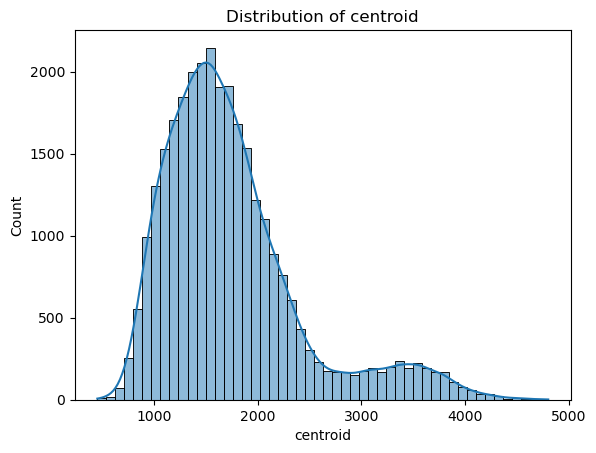

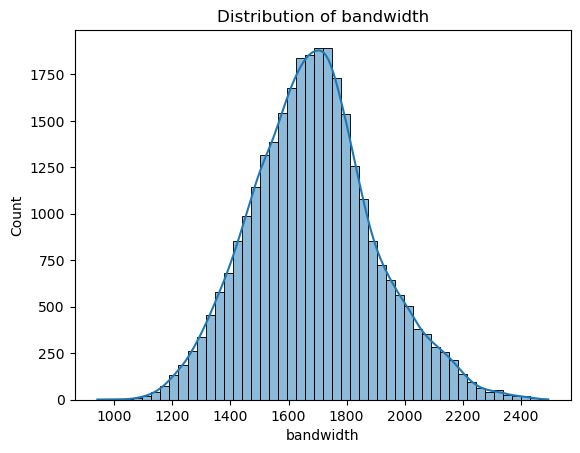

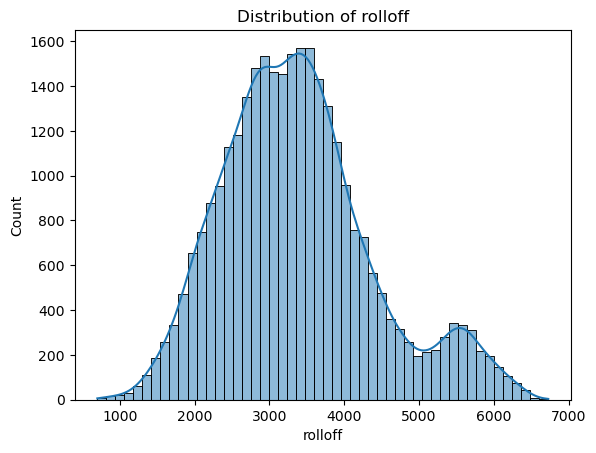

In [40]:
features = ['duration', 'rms', 'zcr', 'centroid', 'bandwidth', 'rolloff']
for feat in features:
    plt.figure()
    sns.histplot(df_audio[feat], kde=True, bins=50)
    plt.title(f"Distribution of {feat}")
    plt.show()

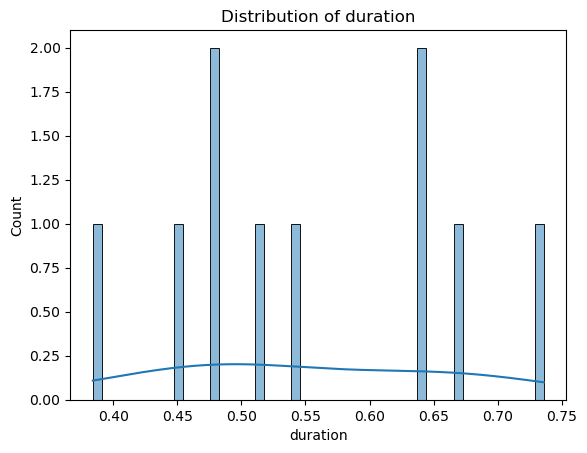

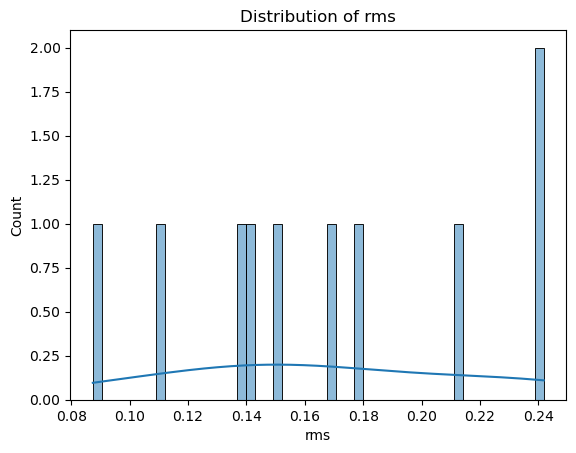

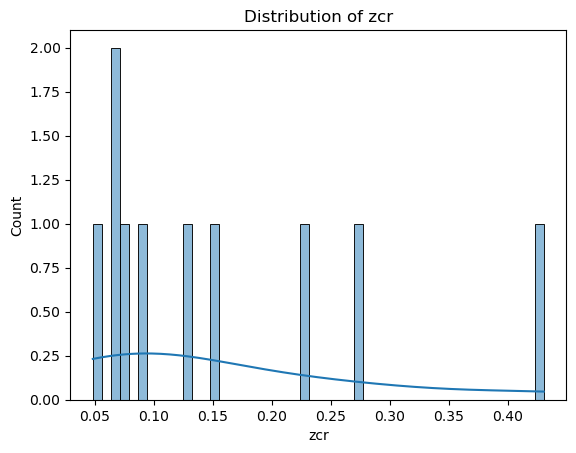

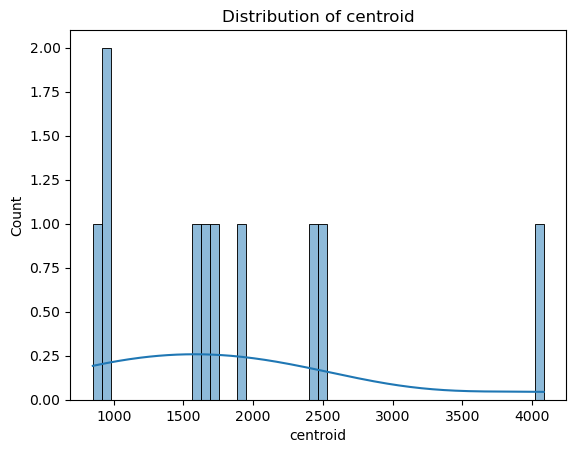

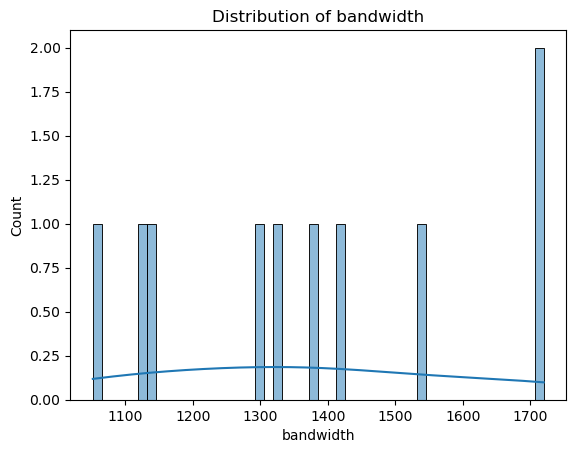

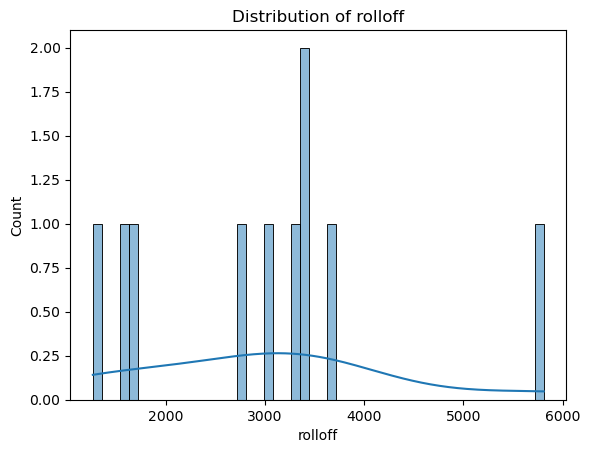

In [43]:
features = ['duration', 'rms', 'zcr', 'centroid', 'bandwidth', 'rolloff']
for feat in features:
    plt.figure()
    sns.histplot(df_querry[feat], kde=True, bins=50)
    plt.title(f"Distribution of {feat}")
    plt.show()

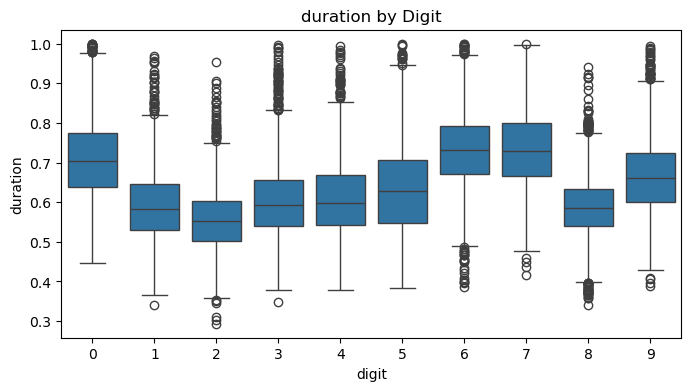

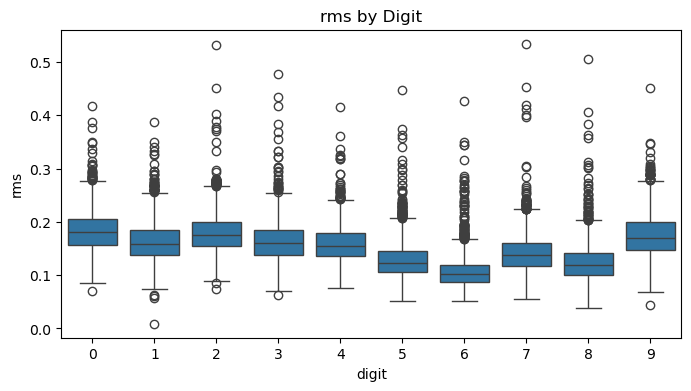

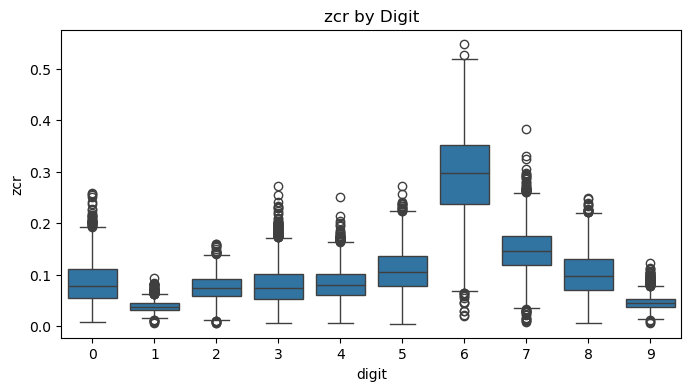

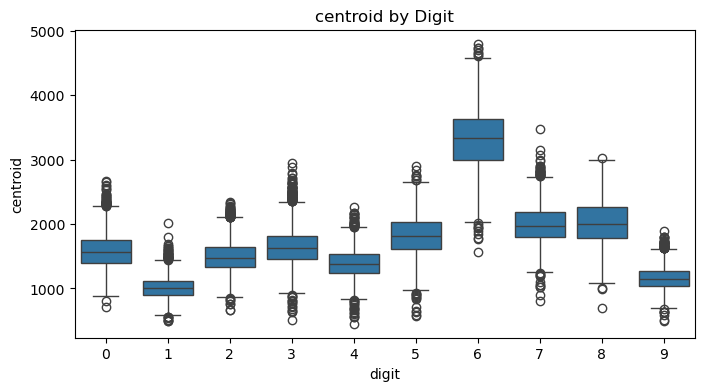

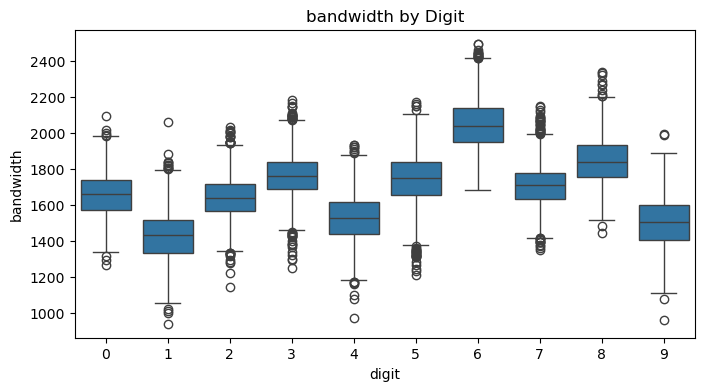

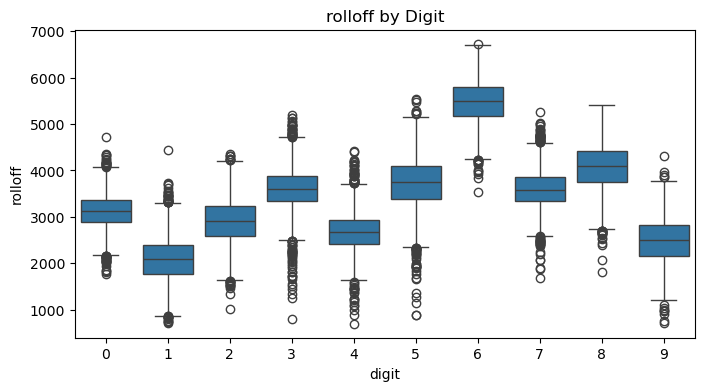

In [41]:
for feat in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="digit", y=feat, data=df_audio)
    plt.title(f"{feat} by Digit")
    plt.show()


As a preprocessing step we have to 
1. Normalise the audio signals before indexing, both collection and query feature vectors.
2. Remove the noise.

In [52]:
# Loading model and preprocessor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").eval()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
def extract_wav2vec_embedding(audio_path, sr=16000):
    waveform, original_sr = torchaudio.load(audio_path)
    if original_sr != sr:
        resampler = torchaudio.transforms.Resample(orig_freq=original_sr, new_freq=sr)
        waveform = resampler(waveform)

    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    input_values = processor(waveform.squeeze().numpy(), return_tensors="pt", sampling_rate=sr).input_values

    with torch.no_grad():
        outputs = model(input_values)

    embeddings = outputs.last_hidden_state

    embedding = embeddings.mean(dim=1).squeeze().numpy().astype("float32")
    return embedding


In [47]:

# Loading FAISS index
index = faiss.read_index("wav2vec_faiss.index")



In [53]:
embedding_before_cleaning = extract_wav2vec_embedding(querry_audio_paths[3])

In [86]:
destination = "denoised_querry"
os.makedirs(destination, exist_ok=True)

for path in querry_audio_paths:
    y, sr = librosa.load(path, sr=None)

    y_denoised = nr.reduce_noise(y=y, sr=sr)
    destination_path = os.path.join(destination, Path(path).name)
    sf.write(destination_path, y_denoised, sr)
    # sf.write(destination_path, y_norm, sr)
    

In [87]:
denoised_audio_paths = [os.path.join(destination,path) for path in os.listdir(destination)]
print(denoised_audio_paths[3])

denoised_querry\3.wav


In [88]:
cos_sim_cleaned = cosine(extract_wav2vec_embedding(denoised_audio_paths[0]), extract_wav2vec_embedding(zero_digit_path))
cos_sim_raw = cosine(extract_wav2vec_embedding(querry_audio_paths[0]), extract_wav2vec_embedding(zero_digit_path))

print(f"Raw similarity: {cos_sim_raw:.3f}")
print(f"Cleaned similarity: {cos_sim_cleaned:.3f}")


Raw similarity: 0.056
Cleaned similarity: 0.069


In [89]:

def precision_at_k(true_label, pred_labels, k):
    return sum(1 for label in pred_labels[:k] if label == true_label) / k

def average_precision(true_label, pred_labels):
    score = 0.0
    count = 0
    for i, label in enumerate(pred_labels):
        if label == true_label:
            count += 1
            score += count / (i + 1)
    return score / count if count > 0 else 0.0

def reciprocal_rank(true_label, pred_labels):
    for i, label in enumerate(pred_labels):
        if label == true_label:
            return 1.0 / (i + 1)
    return 0.0

In [90]:
k = 10
true_labels = []
precisions = []
average_precisions = []
reciprocal_ranks = []
for filename in sorted(os.listdir(destination)):
    digit = str(os.path.splitext(filename)[0])  # assumes filename is the digit
    true_labels.append(digit)

    path = os.path.join(destination, filename)
    # y, _ = librosa.load(path, sr=sr)
    # y = y / np.max(np.abs(y))  # normalize amplitude
    # y, _ = librosa.effects.trim(y, top_db=30)  # trim silence

    # YAMNet Embedding
    embedding = extract_wav2vec_embedding(path)

    # Normalize and Search
    faiss.normalize_L2(embedding.reshape(1, -1))
    D, I = index.search(embedding.reshape(1, -1), k)

    # Evaluate
    retrieved_digits = list(map(str, df_meta.iloc[I[0]]["digit"].tolist()))

    precisions.append(precision_at_k(digit, retrieved_digits, k))
    average_precisions.append(average_precision(digit, retrieved_digits))
    reciprocal_ranks.append(reciprocal_rank(digit, retrieved_digits))

    print(f"\n🎤 Query Digit: {digit}")
    print(f"🔍 Top-{k} Retrieved: {retrieved_digits}")

#Summary 
print("\n📊 Evaluation Summary:")
print(f"Mean Precision@{k}: {np.mean(precisions):.4f}")
print(f"Mean Average Precision (MAP): {np.mean(average_precisions):.4f}")
print(f"Mean Reciprocal Rank (MRR): {np.mean(reciprocal_ranks):.4f}")


🎤 Query Digit: 0
🔍 Top-10 Retrieved: ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

🎤 Query Digit: 1
🔍 Top-10 Retrieved: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']

🎤 Query Digit: 2
🔍 Top-10 Retrieved: ['4', '2', '4', '1', '1', '1', '1', '4', '1', '4']

🎤 Query Digit: 3
🔍 Top-10 Retrieved: ['8', '8', '8', '8', '8', '8', '8', '8', '8', '8']

🎤 Query Digit: 4
🔍 Top-10 Retrieved: ['4', '4', '4', '4', '4', '4', '4', '4', '4', '4']

🎤 Query Digit: 5
🔍 Top-10 Retrieved: ['5', '5', '5', '5', '5', '5', '5', '9', '5', '5']

🎤 Query Digit: 6
🔍 Top-10 Retrieved: ['6', '6', '6', '6', '6', '6', '6', '6', '6', '6']

🎤 Query Digit: 7
🔍 Top-10 Retrieved: ['7', '7', '7', '7', '7', '7', '7', '7', '7', '7']

🎤 Query Digit: 8
🔍 Top-10 Retrieved: ['8', '8', '8', '8', '8', '8', '8', '8', '8', '8']

🎤 Query Digit: 9
🔍 Top-10 Retrieved: ['5', '5', '1', '1', '5', '1', '9', '5', '1', '5']

📊 Evaluation Summary:
Mean Precision@10: 0.7100
Mean Average Precision (MAP): 0.7619
Mean Reciprocal Rank (MR

In [85]:
embedding = extract_wav2vec_embedding("query_raw.wav")
faiss.normalize_L2(embedding.reshape(1, -1))
D, I = index.search(embedding.reshape(1, -1), k)

retrieved_digits = list(map(str, df_meta.iloc[I[0]]["digit"].tolist()))
print(retrieved_digits)

['1', '5', '1', '9', '1', '1', '1', '1', '1', '1']


#### I evaluated the system with denoised recorded audios and the Summary is: - 
* Mean Precision@10: 0.7100
* Mean Average Precision (MAP): 0.7619
* Mean Reciprocal Rank (MRR): 0.7643


Let's try further

In [13]:
df_meta.head()

,accent,gender,age,path,digit
0,german,male,30,C:\Users\shri\Data_Science\Image_generation\au...,0
1,german,male,30,C:\Users\shri\Data_Science\Image_generation\au...,0
2,german,male,30,C:\Users\shri\Data_Science\Image_generation\au...,0
3,german,male,30,C:\Users\shri\Data_Science\Image_generation\au...,0
4,german,male,30,C:\Users\shri\Data_Science\Image_generation\au...,0


In [14]:
df_meta['gender'].value_counts()

gender
male      24000
female     6000
Name: count, dtype: int64

In [15]:
df_meta['age'].value_counts()

age
26      5000
25      3000
23      3000
27      3000
31      2500
24      2000
28      2000
30      2000
22      1500
29      1500
33      1000
36       500
35       500
41       500
32       500
61       500
1234     500
34       500
Name: count, dtype: int64

In [12]:
df_meta['accent'].value_counts()

accent
German                20000
Chinese                1500
Italian                1000
Spanish                1000
French                  500
Danish                  500
Arabic                  500
South African           500
Egyptian_American?      500
german                  500
Brasilian               500
English                 500
Levant                  500
Madras                  500
South Korean            500
German/Spanish          500
Tamil                   500
Name: count, dtype: int64

In [16]:
df_meta['digit'].value_counts()

digit
0    3000
1    3000
2    3000
3    3000
4    3000
5    3000
6    3000
7    3000
8    3000
9    3000
Name: count, dtype: int64

In [17]:
### adding noise and seeing if the results change


In [38]:
def preprocess_and_augment(
    audio_path, 
    sr=16000, 
    target_duration=1.0,
    noise_level_db=-20,
    apply_time_stretch=True,
    stretch_range=(0.9, 1.1)
):
    """
    Load, preprocess, and augment an audio file.
    """
    y, orig_sr = librosa.load(audio_path, sr=sr)

    # Trim silence
    y, _ = librosa.effects.trim(y, top_db=30)

    # RMS normalization
    y = y / (np.max(np.abs(y)) + 1e-8)

    # # Time stretching
    # if apply_time_stretch:
    #     rate = np.random.uniform(stretch_range[0], stretch_range[1])
    #     y = librosa.effects.time_stretch(y)

    # Add Gaussian noise
    rms_signal = np.sqrt(np.mean(y**2))
    noise_rms = rms_signal * (10**(noise_level_db / 20.0))
    noise = np.random.normal(0, noise_rms, y.shape)
    y = y + noise

    # Re-normalize after noise
    y = y / (np.max(np.abs(y)) + 1e-8)

    # Pad or truncate
    target_length = int(sr * target_duration)
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]

    return y, sr



In [39]:
def extract_mfcc(y, sr, n_mfcc=13):
    """
    Extract mean MFCC embedding from audio.
    """
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    embedding = np.mean(mfcc, axis=1)
    return embedding.astype("float32")


In [40]:
embeddings = []

for i, row in tqdm(df_meta.iterrows(), total=len(df_meta)):
    audio_path = row["path"]

    # Preprocess and augment
    y_aug, sr = preprocess_and_augment(
    audio_path=audio_path,
    sr=16000,
    target_duration=1.0,
    noise_level_db=-20,
    apply_time_stretch=True,
    stretch_range=(0.9, 1.1)
)


    # Extract embedding
    emb = extract_mfcc(y_aug, sr)
    embeddings.append(emb)

# Convert list to numpy array
embeddings_array = np.vstack(embeddings)  # Shape: (N, 13)


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [20:52<00:00, 23.95it/s]


In [42]:
embeddings_array.shape

(30000, 13)

In [43]:
index3 = faiss.IndexFlatL2(13)
index3.add(embeddings_array)


In [44]:
def precision_at_k(true_label, pred_labels, k):
    return sum(1 for label in pred_labels[:k] if label == true_label) / k

def average_precision(true_label, pred_labels):
    score = 0.0
    count = 0
    for i, label in enumerate(pred_labels):
        if label == true_label:
            count += 1
            score += count / (i + 1)
    return score / count if count > 0 else 0.0

def reciprocal_rank(true_label, pred_labels):
    for i, label in enumerate(pred_labels):
        if label == true_label:
            return 1.0 / (i + 1)
    return 0.0

# Evaluation loop
k = 10

In [45]:
query_dir = "recorded_queries_clean"
sr = 16000

In [48]:
def preprocess_and_extract_mfcc_query(audio_path, 
                                      sr=16000, 
                                      target_duration=1.0, 
                                      n_mfcc=13):
    """
    Load and preprocess a query audio file and extract MFCC embedding.
    """
    # Load
    y, orig_sr = librosa.load(audio_path, sr=sr)
    
    # Trim silence
    y, _ = librosa.effects.trim(y, top_db=30)
    
    # Normalize RMS
    y = y / (np.max(np.abs(y)) + 1e-8)
    
    # Pad or truncate
    target_length = int(sr * target_duration)
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]
    
    # Extract MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    embedding = np.mean(mfcc, axis=1).astype("float32")
    
    return embedding


In [53]:
true_labels = []
precisions = []
average_precisions = []
reciprocal_ranks = []
# ---- Retrieval and Evaluation Loop ----
for filename in sorted(os.listdir(query_dir)):
    digit = str(os.path.splitext(filename)[0])  # assumes filename is the digit
    true_labels.append(digit)

    path = os.path.join(query_dir, filename)
    # y, _ = librosa.load(path, sr=sr)
    # y = y / np.max(np.abs(y))  # normalize amplitude
    # y, _ = librosa.effects.trim(y, top_db=30)  # trim silence

    # yq, srq = preprocess_audio_mfcc(path)
    qvec = preprocess_and_extract_mfcc_query(path)

    #  Normalize and Search
    # faiss.normalize_L2(embedding.reshape(1, -1))
    D, I = index3.search(qvec.reshape(1, -1), k=10)


    #  Evaluate
    retrieved_digits = list(map(str, df_meta.iloc[I[0]]["digit"].tolist()))

    precisions.append(precision_at_k(digit, retrieved_digits, k))
    average_precisions.append(average_precision(digit, retrieved_digits))
    reciprocal_ranks.append(reciprocal_rank(digit, retrieved_digits))

    print(f"\n🎤 Query Digit: {digit}")
    print(f"🔍 Top-{k} Retrieved: {retrieved_digits}")

# ---- Summary ----
print("\n📊 Evaluation Summary:")
print(f"Mean Precision@{k}: {np.mean(precisions):.4f}")
print(f"Mean Average Precision (MAP): {np.mean(average_precisions):.4f}")
print(f"Mean Reciprocal Rank (MRR): {np.mean(reciprocal_ranks):.4f}")


🎤 Query Digit: 0
🔍 Top-10 Retrieved: ['1', '5', '1', '1', '1', '1', '4', '1', '1', '1']

🎤 Query Digit: 1
🔍 Top-10 Retrieved: ['4', '5', '5', '5', '5', '5', '5', '5', '5', '5']

🎤 Query Digit: 2
🔍 Top-10 Retrieved: ['1', '4', '1', '1', '4', '1', '4', '1', '1', '5']

🎤 Query Digit: 3
🔍 Top-10 Retrieved: ['8', '8', '8', '8', '8', '8', '8', '9', '8', '8']

🎤 Query Digit: 4
🔍 Top-10 Retrieved: ['5', '1', '1', '1', '5', '1', '1', '1', '1', '1']

🎤 Query Digit: 5
🔍 Top-10 Retrieved: ['8', '8', '8', '8', '8', '8', '8', '8', '8', '8']

🎤 Query Digit: 6
🔍 Top-10 Retrieved: ['6', '6', '2', '8', '2', '8', '2', '8', '8', '8']

🎤 Query Digit: 7
🔍 Top-10 Retrieved: ['5', '9', '5', '5', '9', '5', '5', '9', '5', '5']

🎤 Query Digit: 8
🔍 Top-10 Retrieved: ['9', '8', '8', '8', '8', '9', '8', '8', '8', '8']

🎤 Query Digit: 9
🔍 Top-10 Retrieved: ['9', '9', '9', '9', '9', '9', '9', '8', '9', '8']

📊 Evaluation Summary:
Mean Precision@10: 0.1800
Mean Average Precision (MAP): 0.2706
Mean Reciprocal Rank (MR

In [52]:
qvec.shape

(13,)

The performance falls drastically 